In [1]:
!nvidia-smi

Sun Sep  8 20:10:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0    41W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
PRFX = 'CVBbox0908_1'
PREP_PRFX = 'PrepBbox0908'

HOME = '/tmp/working/data/git/cld'
p_output = f'{HOME}/output/{PRFX}'
from pathlib import Path
Path(p_output).mkdir(exist_ok=True)


In [13]:
# cd {HOME}/input

# !git clone https://github.com/fizyr/keras-retinanet.git

# cd {HOME}/input/keras-retinanet/

# !python setup.py build_ext --inplace

# cd {HOME}/input/

# !wget --quiet https://github.com/fizyr/keras-retinanet/releases/download/0.3.1/resnet50_coco_best_v2.1.0.h5

# !pip install {HOME}/input/keras-retinanet --user

- https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/bin/train.py
- http://localhost:8889/notebooks/git/Research/imgcat/nbs/2018-07-05/retinanet_openimages-clothing-parts-crop.ipynb
- https://github.com/fizyr/keras-retinanet/blob/master/examples/ResNet50RetinaNet.ipynb

In [107]:
SEED = 100
PERC_VAL = 0.15
BS = 4
EPOCHS = 50
FN_LBLS = f'{HOME}/output/{PREP_PRFX}/lbls.csv'
SCORE_THRESHOLD = 0.5
INPUT_SHAPE = (1400, 2100)
dbg = False
if dbg: 
    EPOCHS = 1
    dbgsz = 50

In [118]:
import pandas as pd
import numpy as np
import pickle
from skimage.data import imread


# prep

In [17]:
col_names = ['Image', 'x1', 'y1', 'x2', 'y2', 'Label']
df_boxes = pd.read_csv(f'{HOME}/output/{PREP_PRFX}/boxes.csv', header=None, names=col_names)

df_boxes.head()

Image   x1   y1    x2    y2   Label
0  0011165.jpg  189  317  1183  1253    Fish
1  0011165.jpg  968  313  2094  1365  Flower
2  002be4f.jpg  167    9  2086   889    Fish
3  002be4f.jpg  956  878  2097  1396  Flower
4  002be4f.jpg   48  294   944   643   Sugar

In [18]:
if dbg: df_boxes = df_boxes.head(dbgsz)

In [19]:
df_boxes.Image = f'{HOME}/input/train_images/'+df_boxes.Image

In [20]:
imgs = np.array(list(set(df_boxes.Image)))

np.random.seed(SEED)
msk_val = np.random.rand(len(imgs))<PERC_VAL
imgs_trn = imgs[~msk_val]
imgs_val = imgs[msk_val]

print(len(imgs), len(imgs_trn), len(imgs_val))

df_boxes_trn = df_boxes[df_boxes.Image.isin(imgs_trn)]
df_boxes_val = df_boxes[df_boxes.Image.isin(imgs_val)]
print(df_boxes_trn.shape, df_boxes_val.shape)

steps = len(imgs_trn)//BS


5546 4684 862
(10041, 6) (1795, 6)


In [21]:
df_boxes_trn.to_csv(f'{HOME}/output/{PRFX}/boxes_trn.csv', index=False, header=None)
df_boxes_val.to_csv(f'{HOME}/output/{PRFX}/boxes_val.csv', index=False, header=None)

# train

In [22]:
!{HOME}/input/keras-retinanet/keras_retinanet/bin/train.py \
--weights $HOME/input/resnet50_coco_best_v2.1.0.h5 \
--epochs $EPOCHS \
--steps $steps \
--batch-size $BS \
--snapshot-path $p_output \
csv {HOME}/output/{PRFX}/boxes_trn.csv $FN_LBLS --val-annotations {HOME}/output/{PRFX}/boxes_val.csv

Using TensorFlow backend.
2019-09-07 02:15:51.214463: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300095000 Hz
2019-09-07 02:15:51.215210: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x5612681487a0 executing computations on platform Host. Devices:
2019-09-07 02:15:51.215253: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-09-07 02:15:51.990967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-09-07 02:15:51.991942: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x561268218190 executing computations on platform CUDA. Devices:
2019-09-07 02:15:51.991983: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2019-09-07 02:15:51.992807: I tensorflow/core

bn4b_branch2c (BatchNormalizati (None, None, None, 1 4096        res4b_branch2c[0][0]             
__________________________________________________________________________________________________
res4b (Add)                     (None, None, None, 1 0           bn4b_branch2c[0][0]              
                                                                 res4a_relu[0][0]                 
__________________________________________________________________________________________________
res4b_relu (Activation)         (None, None, None, 1 0           res4b[0][0]                      
__________________________________________________________________________________________________
res4c_branch2a (Conv2D)         (None, None, None, 2 262144      res4b_relu[0][0]                 
__________________________________________________________________________________________________
bn4c_branch2a (BatchNormalizati (None, None, None, 2 1024        res4c_branch2a[0][0]             
__________

Epoch 1/50
1171/1171 [==============================] - 774s 661ms/step - loss: 2.4939 - regression_loss: 1.9195 - classification_loss: 0.5745
Running network: N/A% (0 of 862) |       | Elapsed Time: 0:00:00 ETA:  --:--:--2019-09-07 02:29:02.892756: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node clipped_boxes/strided_slice_2. Error: Pack node (boxes/stack) axis attribute is out of bounds: 2
2019-09-07 02:29:02.892841: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node clipped_boxes/strided_slice_3. Error: Pack node (boxes/stack) axis attribute is out of bounds: 2
2019-09-07 02:29:02.892888: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node clipped_boxes/strided_slice_4

Epoch 10/50
1171/1171 [==============================] - 923s 788ms/step - loss: 1.6506 - regression_loss: 1.2948 - classification_loss: 0.3558
Running network: 100% (862 of 862) |#####| Elapsed Time: 0:02:14 Time:  0:02:14
Parsing annotations: 100% (862 of 862) |#| Elapsed Time: 0:00:00 Time:  0:00:00
438 instances of class Fish with average precision: 0.2911
569 instances of class Sugar with average precision: 0.3985
344 instances of class Flower with average precision: 0.5051
444 instances of class Gravel with average precision: 0.2787
mAP: 0.3683

Epoch 00010: saving model to /tmp/working/data/git/cld/output/CVBbox0906_1/resnet50_csv_10.h5
Epoch 11/50
1171/1171 [==============================] - 874s 746ms/step - loss: 1.5915 - regression_loss: 1.2407 - classification_loss: 0.3508
Running network: 100% (862 of 862) |#####| Elapsed Time: 0:02:15 Time:  0:02:15
Parsing annotations: 100% (862 of 862) |#| Elapsed Time: 0:00:00 Time:  0:00:00
438 instances of class Fish with average pre

Epoch 23/50
1171/1171 [==============================] - 811s 693ms/step - loss: 0.9180 - regression_loss: 0.6558 - classification_loss: 0.2622
Running network: 100% (862 of 862) |#####| Elapsed Time: 0:02:13 Time:  0:02:13
Parsing annotations: 100% (862 of 862) |#| Elapsed Time: 0:00:00 Time:  0:00:00
438 instances of class Fish with average precision: 0.2367
569 instances of class Sugar with average precision: 0.3387
344 instances of class Flower with average precision: 0.4620
444 instances of class Gravel with average precision: 0.2381
mAP: 0.3189

Epoch 00023: saving model to /tmp/working/data/git/cld/output/CVBbox0906_1/resnet50_csv_23.h5
Epoch 24/50
1171/1171 [==============================] - 898s 767ms/step - loss: 0.8791 - regression_loss: 0.6252 - classification_loss: 0.2539
Running network: 100% (862 of 862) |#####| Elapsed Time: 0:02:24 Time:  0:02:24
Parsing annotations: 100% (862 of 862) |#| Elapsed Time: 0:00:00 Time:  0:00:00
438 instances of class Fish with average pre

Epoch 36/50
1171/1171 [==============================] - 885s 756ms/step - loss: 0.5914 - regression_loss: 0.4138 - classification_loss: 0.1776
Running network: 100% (862 of 862) |#####| Elapsed Time: 0:02:14 Time:  0:02:14
Parsing annotations: 100% (862 of 862) |#| Elapsed Time: 0:00:00 Time:  0:00:00
438 instances of class Fish with average precision: 0.2072
569 instances of class Sugar with average precision: 0.2997
344 instances of class Flower with average precision: 0.4715
444 instances of class Gravel with average precision: 0.2078
mAP: 0.2966

Epoch 00036: saving model to /tmp/working/data/git/cld/output/CVBbox0906_1/resnet50_csv_36.h5
Epoch 37/50
1171/1171 [==============================] - 867s 740ms/step - loss: 0.5764 - regression_loss: 0.4042 - classification_loss: 0.1722
Running network: 100% (862 of 862) |#####| Elapsed Time: 0:02:13 Time:  0:02:13
Parsing annotations: 100% (862 of 862) |#| Elapsed Time: 0:00:00 Time:  0:00:00
438 instances of class Fish with average pre

Epoch 49/50
1171/1171 [==============================] - 873s 745ms/step - loss: 0.4314 - regression_loss: 0.3107 - classification_loss: 0.1208
Running network: 100% (862 of 862) |#####| Elapsed Time: 0:02:13 Time:  0:02:13
Parsing annotations: 100% (862 of 862) |#| Elapsed Time: 0:00:00 Time:  0:00:00
438 instances of class Fish with average precision: 0.2107
569 instances of class Sugar with average precision: 0.2679
344 instances of class Flower with average precision: 0.4471
444 instances of class Gravel with average precision: 0.1841
mAP: 0.2774

Epoch 00049: saving model to /tmp/working/data/git/cld/output/CVBbox0906_1/resnet50_csv_49.h5
Epoch 50/50
1171/1171 [==============================] - 856s 731ms/step - loss: 0.4228 - regression_loss: 0.3056 - classification_loss: 0.1171
Running network: 100% (862 of 862) |#####| Elapsed Time: 0:02:21 Time:  0:02:21
Parsing annotations: 100% (862 of 862) |#| Elapsed Time: 0:00:00 Time:  0:00:00
438 instances of class Fish with average pre

In [23]:
dd='11'

fn_mdl = f"resnet50_csv_{dd}.h5"
pth_mdl = f"{p_output}/{fn_mdl}"
pth_pred_mdl = f"{p_output}/prd_{fn_mdl}"

fn_mdl, pth_mdl, pth_pred_mdl

('resnet50_csv_11.h5',
 '/tmp/working/data/git/cld/output/CVBbox0906_1/resnet50_csv_11.h5',
 '/tmp/working/data/git/cld/output/CVBbox0906_1/prd_resnet50_csv_11.h5')

# pred

## demo

In [24]:
!{HOME}/input/keras-retinanet/keras_retinanet/bin/convert_model.py  $pth_mdl $pth_pred_mdl

Using TensorFlow backend.
2019-09-07 19:03:12.842446: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300095000 Hz
2019-09-07 19:03:12.843075: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55f4958ec600 executing computations on platform Host. Devices:
2019-09-07 19:03:12.843116: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-09-07 19:03:13.503129: E tensorflow/stream_executor/cuda/cuda_driver.cc:300] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2019-09-07 19:03:13.503187: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:161] retrieving CUDA diagnostic information for host: ecf33a102628
2019-09-07 19:03:13.503207: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:168] hostname: ecf33a102628
2019-09-07 19:03:13.503318: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:192] libcuda reported version is: 418.56.0
2019-09-07 19:03:13.503359

In [25]:
from keras_retinanet.models import load_model
import time
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import matplotlib.pyplot as plt
import cv2

In [26]:
nm2lbl = dict(pd.read_csv(FN_LBLS, header=None).values)
lbl2nm = {v:k for k,v in nm2lbl.items()}

In [27]:
model = load_model(pth_pred_mdl, backbone_name='resnet50')

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [56]:
def demo_retinanet(img):
    print(img)
    # load image
    image = read_image_bgr(img)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    score_threshold_draw = 0.5
    score_threshold_print = 0.5
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if label < 0: continue
        if score < score_threshold_print: break
        print(lbl2nm[label], score)  
        if score < score_threshold_draw: continue
        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(lbl2nm[label], score)
        draw_caption(draw, b, caption)
    plt.figure(figsize=(50, 50))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [57]:
img = df_boxes_val.Image.sample().values[0]

/tmp/working/data/git/cld/input/train_images/77e9ab3.jpg
processing time:  0.04490852355957031


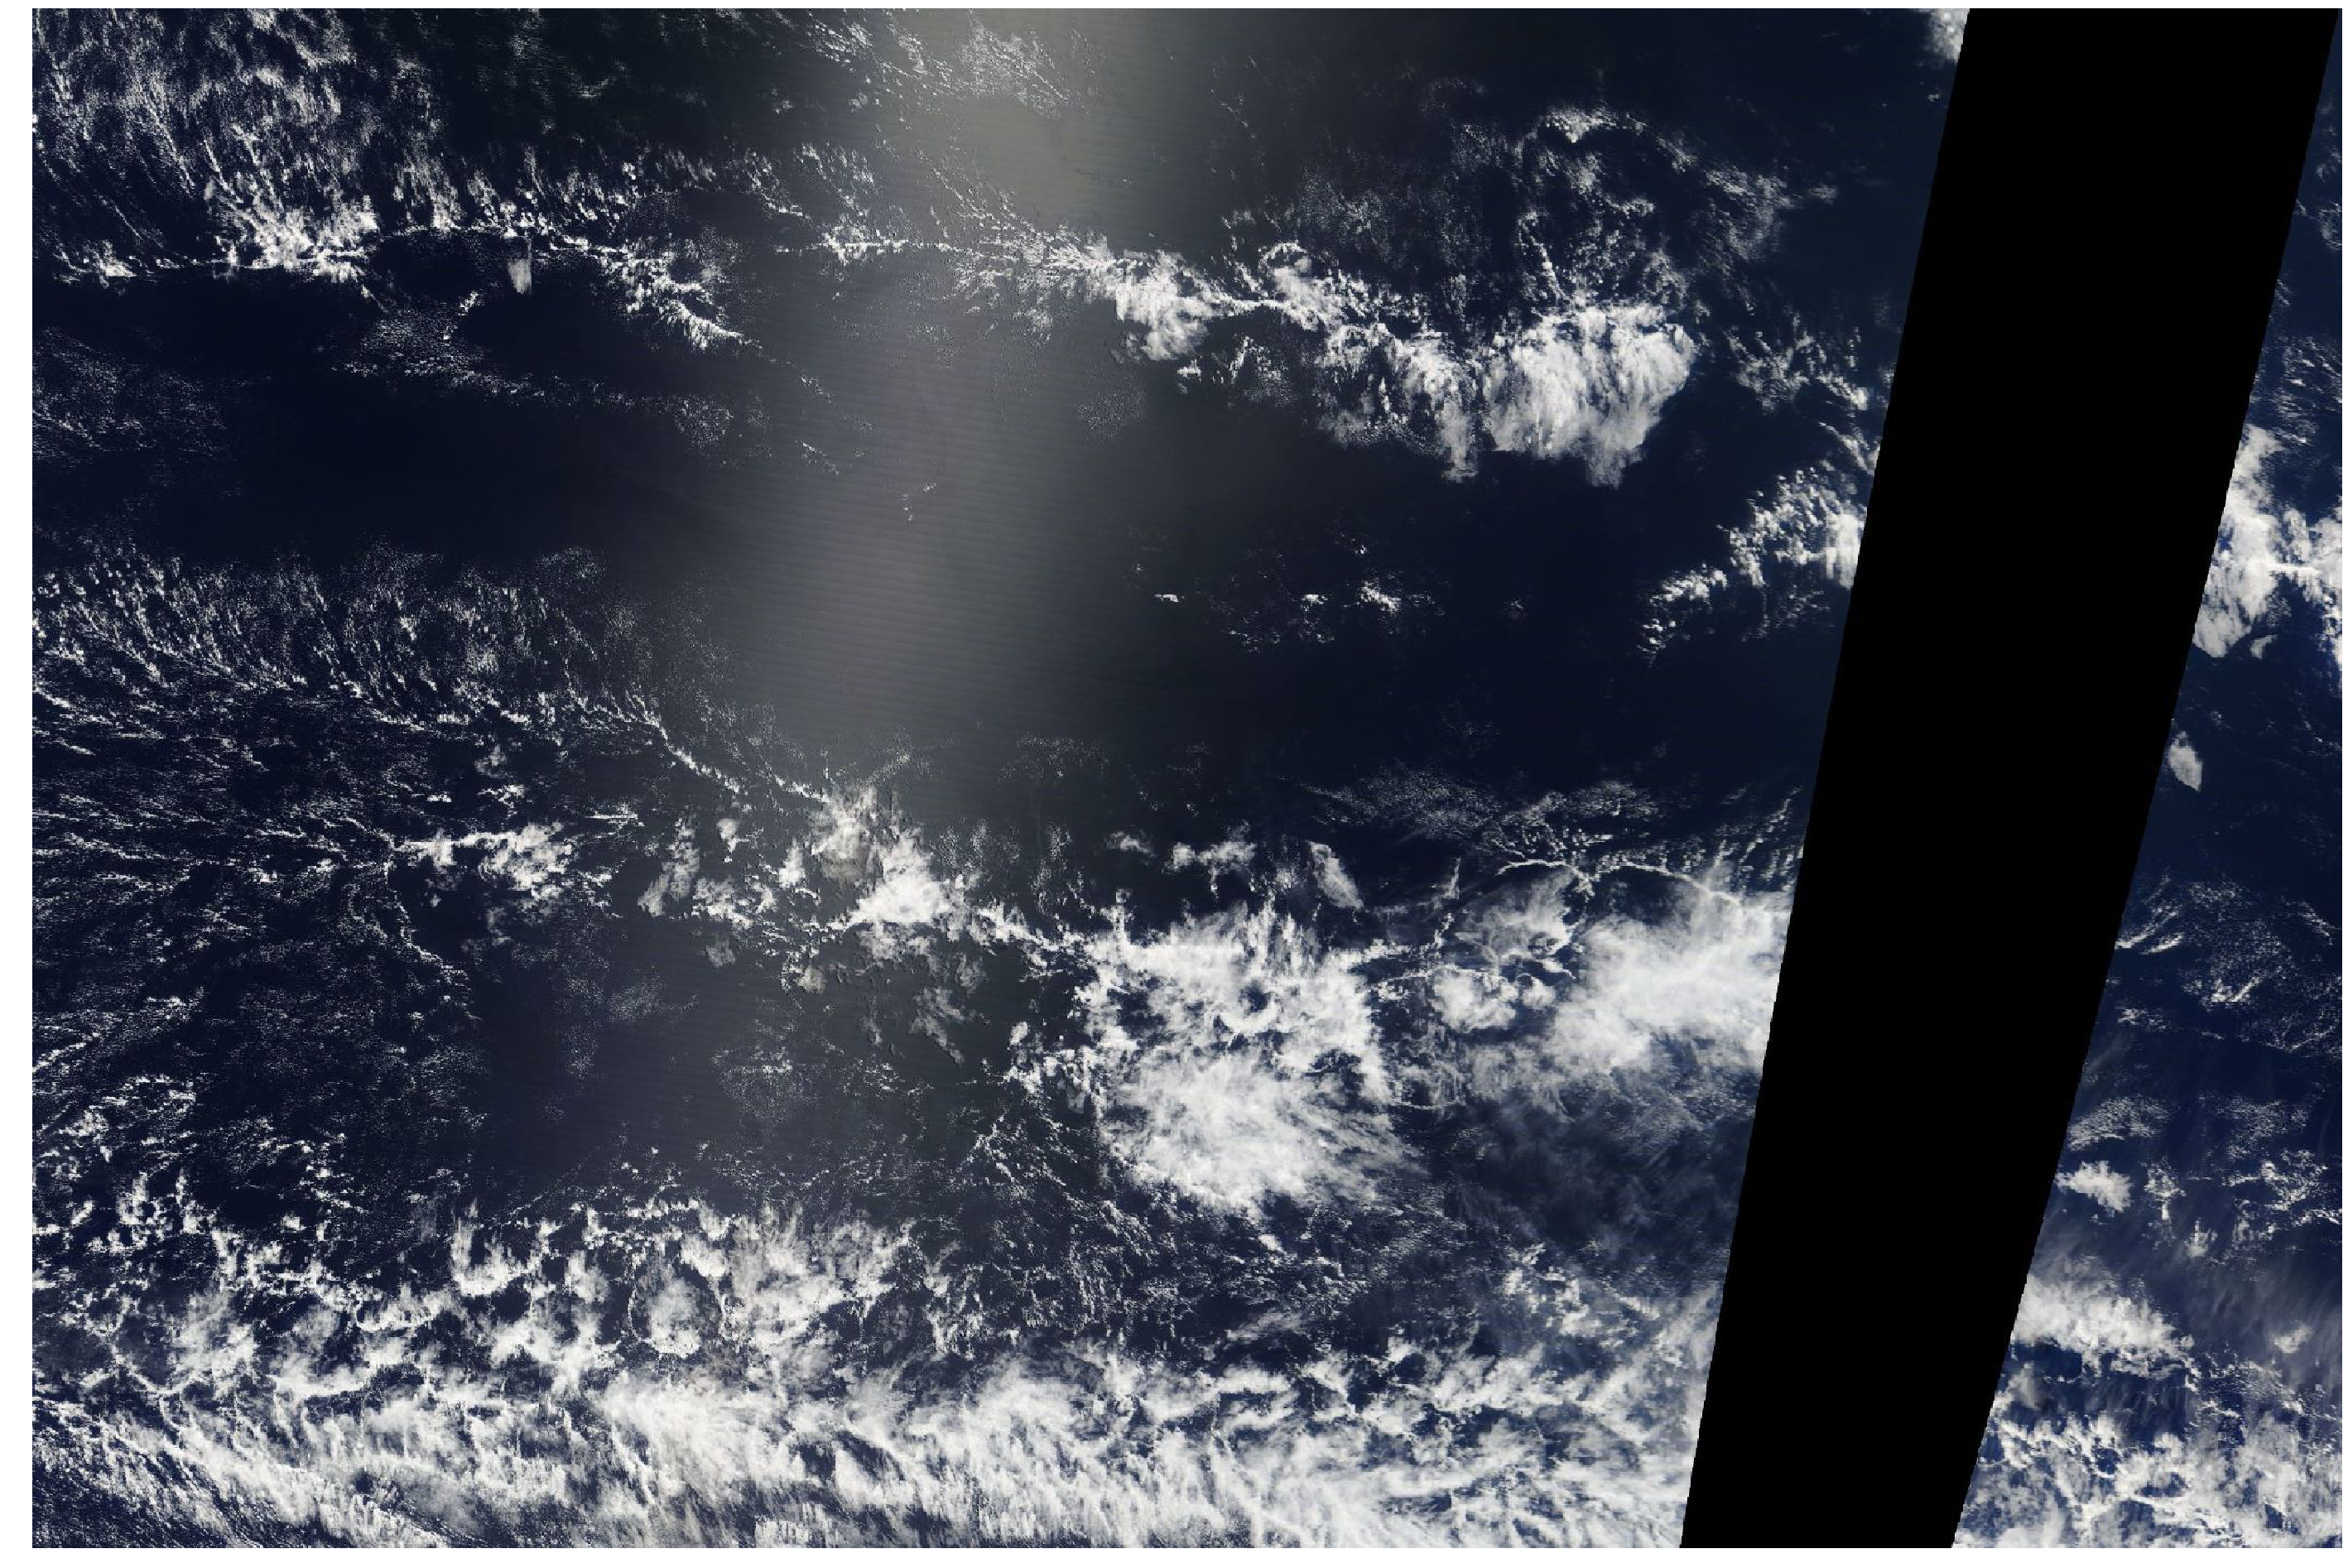

In [58]:
demo_retinanet(img)

## pred on test

In [70]:
import datetime

lst_res = [] 
test_images = list(Path(f'{HOME}/input/test_images').iterdir())
for i, fn_img in enumerate(test_images):
    if (i+1)%100==0: 
        print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} {i+1}/{len(test_images)}")

    image = read_image_bgr(fn_img)
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    # correct for image scale
    boxes /= scale
    lst_res.append((boxes, scores, labels))

2019-09-07 19:27:58 100/3698
2019-09-07 19:28:13 200/3698
2019-09-07 19:28:28 300/3698
2019-09-07 19:28:43 400/3698
2019-09-07 19:28:57 500/3698
2019-09-07 19:29:13 600/3698
2019-09-07 19:29:28 700/3698
2019-09-07 19:29:42 800/3698
2019-09-07 19:29:57 900/3698
2019-09-07 19:30:13 1000/3698
2019-09-07 19:30:28 1100/3698
2019-09-07 19:30:42 1200/3698
2019-09-07 19:30:57 1300/3698
2019-09-07 19:31:12 1400/3698
2019-09-07 19:31:27 1500/3698
2019-09-07 19:31:42 1600/3698
2019-09-07 19:31:57 1700/3698
2019-09-07 19:32:12 1800/3698
2019-09-07 19:32:27 1900/3698
2019-09-07 19:32:42 2000/3698
2019-09-07 19:32:57 2100/3698
2019-09-07 19:33:13 2200/3698
2019-09-07 19:33:28 2300/3698
2019-09-07 19:33:44 2400/3698
2019-09-07 19:33:59 2500/3698
2019-09-07 19:34:15 2600/3698
2019-09-07 19:34:30 2700/3698
2019-09-07 19:34:45 2800/3698
2019-09-07 19:35:01 2900/3698
2019-09-07 19:35:16 3000/3698
2019-09-07 19:35:32 3100/3698
2019-09-07 19:35:47 3200/3698
2019-09-07 19:36:02 3300/3698
2019-09-07 19:36:17

In [98]:
fn_mdl = f"resnet50_csv_{dd}.h5"
pth_res = f"{p_output}/{fn_mdl}_res.p"
pickle.dump(lst_res, open(pth_res, 'wb'))

In [99]:
lst_res = pickle.load(open(pth_res, 'rb'))

In [104]:
score_threshold = SCORE_THRESHOLD
lst_res2keep = []
for res in lst_res:
    res2keep = []
    # visualize detections
    boxes, scores, labels = [o[0] for o in res]
    for box, score, label in zip(boxes, scores, labels):
        # scores are sorted so we can break
        if label < 0: continue
        if score < score_threshold: break
        box = box.astype(int)
        res2keep.append((box, score, label))
    lst_res2keep.append(res2keep)

In [115]:
len(lst_res2keep)

3698

In [105]:
lst_res2keep[:10]

[[(array([ 572,   10, 1668,  628]), 0.5207893, 1)],
 [],
 [(array([  25,   21, 1350,  911]), 0.56992185, 3)],
 [(array([  13,   22, 1382, 1176]), 0.53562427, 1)],
 [(array([ 733,   14, 2081,  738]), 0.6342882, 2),
  (array([ 245,  523, 1810, 1260]), 0.5191963, 1)],
 [(array([ 248,  259, 2074, 1375]), 0.6474549, 1)],
 [],
 [],
 [],
 []]

## box2 rle

In [108]:
def rle2box(mask_rle, shape=INPUT_SHAPE):
    img_msk = rle2mask(mask_rle)
    [(y_1, y_2), (x_1, x_2)]= [(o.min(), o.max()) for o in np.where(img_msk==1)]
    return x_1, y_1, x_2, y_2


def rle2mask(mask_rle, shape=INPUT_SHAPE):
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img_msk = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img_msk[lo:hi] = 1
    return img_msk.reshape(shape, order='F')  # Needed to align to RLE direction

# https://www.kaggle.com/xhlulu/satellite-clouds-u-net-with-resnet-encoder
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# https://www.kaggle.com/zhangyang/clddevbboxmask0906-1


def box2mask(box, shape=INPUT_SHAPE):
    x_1, y_1, x_2, y_2 = box
    mask = np.zeros(shape)
    mask[y_1:y_2, x_1:x_2]=1
    return mask

def box2rle(box, img=None, shape=INPUT_SHAPE):
    mask = box2mask(box, shape)
    if img is not None: mask[img.sum(-1)==0]=0
    mask_rle = mask2rle(mask)
    return mask_rle

In [114]:
lbl2i = dict(pd.read_csv(FN_LBLS, header=None).values)
i2lbl = {v:k for k,v in lbl2i.items()}
i2lbl

{0: 'Fish', 1: 'Sugar', 2: 'Flower', 3: 'Gravel'}

In [162]:
res_subm = []
for i, fn_img in enumerate(test_images):
    if (i+1)%100==0: 
        print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} {i+1}/{len(test_images)}")
    res = lst_res2keep[i]
    if len(res)==0: continue
    img = imread(fn_img)
    for box, score, i_lbl in res:
        predicted_rle = box2rle(box, img=img)
        lbl = i2lbl[i_lbl]
        res_subm.append((f'{fn_img.stem}.jpg_{lbl}', predicted_rle))

2019-09-07 20:21:33 100/3698
2019-09-07 20:21:43 200/3698
2019-09-07 20:21:52 300/3698
2019-09-07 20:22:02 400/3698
2019-09-07 20:22:13 500/3698
2019-09-07 20:22:23 600/3698
2019-09-07 20:22:33 700/3698
2019-09-07 20:22:42 800/3698
2019-09-07 20:22:51 900/3698
2019-09-07 20:23:01 1000/3698
2019-09-07 20:23:10 1100/3698
2019-09-07 20:23:18 1200/3698
2019-09-07 20:23:27 1300/3698
2019-09-07 20:23:38 1400/3698
2019-09-07 20:23:48 1500/3698
2019-09-07 20:23:57 1600/3698
2019-09-07 20:24:04 1700/3698
2019-09-07 20:24:14 1800/3698
2019-09-07 20:24:23 1900/3698
2019-09-07 20:24:31 2000/3698
2019-09-07 20:24:41 2100/3698
2019-09-07 20:24:50 2200/3698
2019-09-07 20:25:00 2300/3698
2019-09-07 20:25:09 2400/3698
2019-09-07 20:25:19 2500/3698
2019-09-07 20:25:29 2600/3698
2019-09-07 20:25:37 2700/3698
2019-09-07 20:25:46 2800/3698
2019-09-07 20:25:57 2900/3698
2019-09-07 20:26:06 3000/3698
2019-09-07 20:26:17 3100/3698
2019-09-07 20:26:27 3200/3698
2019-09-07 20:26:37 3300/3698
2019-09-07 20:26:47

In [172]:
dct_res_subm = dict(res_subm)

## submission

In [190]:
sample_submission = pd.read_csv(f'{HOME}/input/sample_submission.csv')
sample_submission.head()

Image_Label EncodedPixels
0    002f507.jpg_Fish           1 1
1  002f507.jpg_Flower           1 1
2  002f507.jpg_Gravel           1 1
3   002f507.jpg_Sugar           1 1
4    0035ae9.jpg_Fish           1 1

In [191]:
len(test_images), len(test_images)*4, sample_submission.shape, len(res_subm)

(3698, 14792, (14792, 2), 2291)

In [192]:
for i, image_label in enumerate(sample_submission.Image_Label):
    sample_submission.EncodedPixels[i] = dct_res_subm.get(image_label, '')

In [193]:
sample_submission.head()

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  30820 1322 32220 1322 33620 1322 35020 1322 36...
3   002f507.jpg_Sugar                                                   
4    0035ae9.jpg_Fish

In [194]:
sample_submission.sample(5)

Image_Label                                      EncodedPixels
11141  c24ed11.jpg_Flower  165278 1318 166678 1318 168078 1318 169478 131...
2267    244c0f9.jpg_Sugar                                                   
14028    f38ef1d.jpg_Fish                                                   
2962   317c000.jpg_Gravel                                                   
1729   1b27278.jpg_Flower  1716640 1113 1718040 1113 1719440 1113 1720840...

In [206]:
f'{p_output}/{fn_mdl}_submission.csv'

'/tmp/working/data/git/cld/output/CVBbox0906_1/resnet50_csv_11.h5_submission.csv'

In [207]:
sample_submission.to_csv(f'{p_output}/{fn_mdl}_submission.csv', index=False)